In [12]:
# Created Jan 9, 2022
# Updated Jan 9, 2022

import sys
sys.path.append('../')

import sys; sys.path.insert(0, '../../') ## make sure path to root of project directory
from wu_barcodes.config import *
from data.wu_data import *

import matplotlib as mpl
import matplotlib.pyplot as plt
import methods.ax_methods as ax_methods
mpl.rcParams.update(mpl_configs)
import numpy as np; rnd = np.random.default_rng()
import scipy.stats

import pickle

In [13]:
import methods.filter_lineages as fl

import scipy.ndimage.filters as ndif
def running_mean_uniform_filter1d(x, N):
    return ndif.uniform_filter1d(x, N, mode='reflect', origin=0)

def heat_map(ax, bac, m1, m2, day, day0_read_range):
    print('*** Plotting joint distribution of reads ***')
    row_ids = fl.bac_row_ids[bac]
    notWu = fl.bac_nonwu_indices[bac]
    read_array = fl.bac_read_arrays[bac][:, notWu]

    d0_reads = read_array[0]

    m1_reads = np.copy( read_array[ row_ids[(m1, day)] ] )
    m2_reads = np.copy( read_array[ row_ids[(m2, day)] ] )

    print(f'Seq. Depths of Mice={(m1_reads.sum(), m2_reads.sum())}')

    day0_min, day0_max = day0_read_range
    lineage_indices = (d0_reads >= day0_min) * (d0_reads < day0_max) #* (m1_d4_reads > 0) * (m2_d4_reads > 0)
    print(f'# lineages={lineage_indices.sum()}')

    ## plot empirical
    binspace = np.linspace(0, 80, 81)
    ax.hist2d(m1_reads[lineage_indices], m2_reads[lineage_indices], bins=binspace, norm=mpl.colors.LogNorm(0.1, 100), cmap=mpl.cm.Oranges)
    r, pval = scipy.stats.pearsonr(m1_reads[lineage_indices], m2_reads[lineage_indices])
    print(f'r, pval = {r:.2f}, {pval:.1e}')

    ax.set_xlabel('mouse {} day 4 reads'.format(m1))
    ax.set_ylabel('mouse {} day 4 reads'.format(m2))

    ax.set_xlim(0, 80)
    ax.set_ylim(0, 80)
    ax.axvspan( day0_min * m1_reads.sum() / d0_reads.sum(), day0_max * m1_reads.sum() / d0_reads.sum(), color='grey', alpha=0.5, zorder=0)
    ax.axhspan( day0_min * m2_reads.sum() / d0_reads.sum(), day0_max * m2_reads.sum() / d0_reads.sum(), color='grey', alpha=0.5, zorder=0)
    ax.plot( ax.get_xlim(), np.array(ax.get_xlim()) * m2_reads.sum()/m1_reads.sum(), color='black', linestyle='dashed')

def calc_coarse_grained_lfc_array(freqs0, D0, freqs1, D1, dt, coarse_grain=100):
    cg_freqs0 = running_mean_uniform_filter1d(freqs0, coarse_grain)
    cg_freqs1 = running_mean_uniform_filter1d(freqs1, coarse_grain)

    cg_f0, cg_f1 = fl.maxmin_freqs(cg_freqs0, D0, cg_freqs1, D1)

    with np.errstate(divide='ignore'):
        return np.log( cg_f1/cg_f0 ) / dt

with open('../figure1_muller_and_transition/10biggest_indices_v2.pkl', 'rb') as f:
    muller_lineage_dict = pickle.load(f)

In [14]:
BACTERIA_INPUT_SPLITS_DICT = {'BWH2': np.array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22]),
                            'BtVPI': np.array([ 0, 2, 4, 6, 8, 10, 12, 14, 16, 17, 18, 20, 22]),
                            'Bovatus': np.array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22]),
                            'Bt7330': np.array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22])}

/Users/daniel/Documents/GoodLab/wu_barcodes_clean/jupyter/biorxiv_plot_scripts/../../methods/filter_lineages.py:282: RuntimeWarning: divide by zero encountered in log
  return np.log( freqs1/freqs0 ) / dt
/Users/daniel/Documents/GoodLab/wu_barcodes_clean/jupyter/biorxiv_plot_scripts/../../methods/filter_lineages.py:282: RuntimeWarning: divide by zero encountered in log
  return np.log( freqs1/freqs0 ) / dt
/Users/daniel/Documents/GoodLab/wu_barcodes_clean/jupyter/biorxiv_plot_scripts/../../methods/filter_lineages.py:282: RuntimeWarning: divide by zero encountered in log
  return np.log( freqs1/freqs0 ) / dt
/Users/daniel/Documents/GoodLab/wu_barcodes_clean/jupyter/biorxiv_plot_scripts/../../methods/filter_lineages.py:282: RuntimeWarning: divide by zero encountered in log
  return np.log( freqs1/freqs0 ) / dt
/Users/daniel/Documents/GoodLab/wu_barcodes_clean/jupyter/biorxiv_plot_scripts/../../methods/filter_lineages.py:282: RuntimeWarning: divide by zero encountered in log
  return np.l

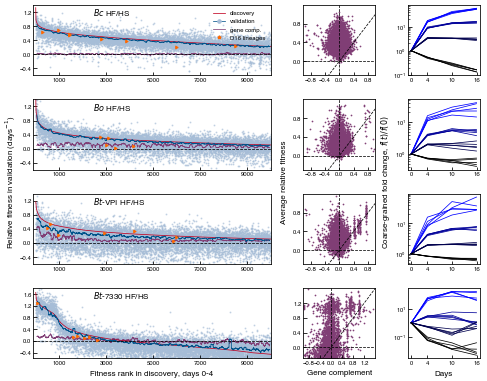

In [18]:
RANK_ORDER_FORMATS = {'BWH2': (20000, [1000, 5000, 10000, 15000, 19000], ['1000', '5000', '10000', '15000', '19000']),
                      'Bovatus': (10000, [1000, 3000, 5000, 7000, 9000], ['1000', '3000', '5000', '7000', '9000']),
                      'BtVPI': (10000, [1000, 3000, 5000, 7000, 9000], ['1000', '3000', '5000', '7000', '9000']),
                      'Bt7330': (5000, [500, 1500, 2500, 3500, 4500], ['500', '1500', '2500', '3500', '4500'])}

fig = plt.figure(figsize=(8,6.5))
outer = mpl.gridspec.GridSpec(nrows=7, ncols=7,
                              height_ratios=[1, 0.1, 1, 0.1, 1, 0.1, 1], width_ratios=[1,1,1,0.15,1,0.15,1], figure=fig)

all_ax_rank = fig.add_subplot(outer[:, 0:3])
all_ax_rank.set_ylabel('Relative fitness in validation (days$^{-1}$)', fontsize=8, labelpad=5)
all_ax_rank.set_xlabel('Fitness rank in discovery, days 0-4', fontsize=8, labelpad=5)
ax_methods.turn_off_ax(all_ax_rank)

all_ax_gene = fig.add_subplot(outer[:, 4:5])
all_ax_gene.set_ylabel('Average relative fitness', fontsize=8, labelpad=5)
all_ax_gene.set_xlabel('Gene complement', fontsize=8, labelpad=4)
ax_methods.turn_off_ax(all_ax_gene)

all_ax_temporal = fig.add_subplot(outer[:, 6:7])
all_ax_temporal.set_ylabel('Coarse-grained fold change, $f(t)/f(0)$', fontsize=8, labelpad=5)
all_ax_temporal.set_xlabel('Days', fontsize=8, labelpad=5)
ax_methods.turn_off_ax(all_ax_temporal)



if 'plot rank order curves, etc':
    min_reads = 5
    gene_nn = False
    cutoff = 10**-6.5
    cg = 100 #coarse_grain

    # discovery_mice = [11, 12, 13, 15]
    # validation_mice = [16, 18, 19]

    discovery_mice = [6, 7, 8, 9, 10]
    validation_mice = [1, 2, 3, 5]

    # discovery_mice = [6, 7, 8]
    # validation_mice = [9, 10]
    # validation_mice = [1, 2, 3, 5]
    # validation_mice = [16, 18, 19]

    # discovery_mice = [16, 18, 19]
    # validation_mice = [11, 12, 13, 15]

    discovery_d0, discovery_d1 = 0, 4
    discovery_dt = discovery_d1 - discovery_d0
    validation_d0, validation_d1 = 0, 4
    validation_dt = validation_d1 - validation_d0
    panel_indices = {'BWH2':['$\\bf{(c)}$', '$\\bf{(d)}$', '$\\bf{(e)}$'],
                 'BtVPI':['$\\bf{(f)}$', '$\\bf{(g)}$', '$\\bf{(h)}$'],
                 'Bovatus':['$\\bf{(f)}$', '$\\bf{(g)}$', '$\\bf{(h)}$'],
                     'Bt7330':['$\\bf{(f)}$', '$\\bf{(g)}$', '$\\bf{(h)}$']}

for b, (bac, n_fit) in enumerate([('BWH2', 10000), ('Bovatus', 10000), ('BtVPI', 10000), ('Bt7330', 10000)]):
# for b, (bac, n_fit) in enumerate([('BWH2', 20000), ('Bovatus', 20000), ('BtVPI', 20000), ('Bt7330', 20000)]):
    if 'generate discovery and validation frequencies':
        discovery_reads0, discovery_reads1 = np.copy(fl.get_read_arrays(bac, discovery_mice, discovery_d0, discovery_d1, split_day0=2))
        validation_reads0, validation_reads1 = np.copy(fl.get_read_arrays(bac, validation_mice, validation_d0, validation_d1, split_day0=1))
        # discovery_reads0 -= fl.bac_input_arrays[bac][6][fl.bac_nonwu_indices[bac]]

        discovery_D0, discovery_D1 = discovery_reads0.sum(), discovery_reads1.sum()
        discovery_freqs0, discovery_freqs1 = discovery_reads0 / discovery_D0, discovery_reads1 / discovery_D1

        validation_D0, validation_D1 = validation_reads0.sum(), validation_reads1.sum()
        validation_freqs0, validation_freqs1 = validation_reads0 /validation_D0, validation_reads1 /validation_D1

        d0_reads = fl.bac_read_arrays[bac][0][fl.bac_nonwu_indices[bac]]
        d0_freqs = d0_reads / d0_reads.sum()
        d1_reads = (discovery_reads1 + validation_reads1)

        max_freqs = np.max([discovery_freqs0, discovery_freqs1], axis=0)
        d_valid = fl.filter_lineages(discovery_reads0, discovery_reads1, min_reads=min_reads, threshold=max_freqs)
        v_valid = fl.filter_lineages(validation_reads0, validation_reads1, min_reads=min_reads, threshold=max_freqs)

        filtered_bool =  (d0_freqs > cutoff) * v_valid #* d_valid
        lineage_indices = rnd.permutation( np.arange(d0_freqs.shape[-1])[filtered_bool] )

        d_f0, d_f1 = fl.maxmin_freqs(discovery_freqs0, discovery_D0, discovery_freqs1, discovery_D1)
        v_f0, v_f1 = fl.maxmin_freqs(validation_freqs0, validation_D0, validation_freqs1, validation_D1)

    if 'generate sorted fitnesses':
        # n_fit = len(lineage_indices)
        fit_indices, sorted_fitnesses = fl.rank_barcodes(d_f0[lineage_indices], d_f1[lineage_indices], discovery_dt)
        fit_indices = lineage_indices[fit_indices]

        # n_fit = filtered_bool.sum()
        v_f0_fit, v_f1_fit = v_f0[fit_indices][:n_fit], v_f1[fit_indices][:n_fit]
        d_freqs0_fit, d_freqs1_fit = discovery_freqs0[fit_indices][:n_fit], discovery_freqs1[fit_indices][:n_fit]
        v_freqs0_fit, v_freqs1_fit = validation_freqs0[fit_indices][:n_fit], validation_freqs1[fit_indices][:n_fit]
        validation_lfcs = fl.calc_lfc_array(v_f0_fit, v_f1_fit, validation_dt)

        cg_validate_lfcs = calc_coarse_grained_lfc_array(v_freqs0_fit, validation_D0, v_freqs1_fit, validation_D1,
                                                         validation_dt, coarse_grain=cg)
        gene_complement_f0, gene_complement_f1 = fl.calc_gene_complement_freqs(bac, fit_indices[:n_fit], validation_freqs0, validation_freqs1, nearest_neighbors=gene_nn, cutoff=cutoff)
        cg_gene_complement_lfcs = calc_coarse_grained_lfc_array(gene_complement_f0, validation_D0, gene_complement_f1, validation_D1,
                                                                validation_dt, coarse_grain=cg)

    if 'rank order plot':
        ax_rank_order = fig.add_subplot(outer[2*b, 0:3])
        ax_rank_order.plot(np.arange(n_fit), sorted_fitnesses[:n_fit], KELLY_COLORS[4], label="discovery fitness")
        ax_rank_order.scatter(np.arange(validation_lfcs.shape[-1]), validation_lfcs, s=1, color=KELLY_COLORS[3],
                              rasterized=True, zorder=0, alpha=0.5)
        ax_rank_order.plot(np.arange(cg_validate_lfcs.shape[-1])[cg//2:-cg//2],
                            cg_validate_lfcs[cg//2:-cg//2], KELLY_COLORS[9], label="coarse-grained lineage")
        ax_rank_order.plot(np.arange(cg_gene_complement_lfcs.shape[-1])[cg//2:-cg//2],
                            cg_gene_complement_lfcs[cg//2:-cg//2], KELLY_COLORS[1], zorder=0, label="gene complement")
        muller_lineages = muller_lineage_dict[bac]['LF']
        muller_ranks = []
        for muller_lineage in muller_lineages:
            try: muller_ranks.append(np.where(fit_indices[:n_fit]==muller_lineage)[0][0])
            except: continue
        muller_ranks = np.array(muller_ranks)
        ax_rank_order.scatter(np.arange(validation_lfcs.shape[-1])[muller_ranks], validation_lfcs[muller_ranks], s=10, marker=(3, 0, -90), color=DIET_COLORS['HF'], rasterized=True, zorder=10)

        if bac == 'BWH2':
            legend_markers = [ax_methods.make_marker_obj(color=KELLY_COLORS[4]),
                              ax_methods.make_marker_obj(color=KELLY_COLORS[9], marker='o', mec=KELLY_COLORS[3], mfc=KELLY_COLORS[3], markersize=3.5),
                              ax_methods.make_marker_obj(color=KELLY_COLORS[1]),
                              ax_methods.make_marker_obj(color=DIET_COLORS['HF'], linewidth=0, marker='*', mfc=DIET_COLORS['HF'], mec=DIET_COLORS['HF'], markersize=3.5)]
            ax_rank_order.legend(legend_markers, ['discovery', 'validation', 'gene comp.', 'D16 lineages'],
                                 fontsize=6, loc=1, frameon=False)

    if 'format rank order plot':
        _, xticks, xtick_labels = RANK_ORDER_FORMATS['Bovatus']
        ax_rank_order.set_xticks(xticks)
        ax_rank_order.set_xticklabels(xtick_labels)
        ax_rank_order.set_xlim(-n_fit/100, n_fit)
        ax_rank_order.set_ylim(-0.6, 1.4)
        y_ticks = [-0.4, 0, 0.4, 0.8, 1.2]
        if bac == 'Bt7330':
            ax_rank_order.set_ylim(-0.6, 1.8)
            y_ticks = [-0.4, 0, 0.4, 0.8, 1.2, 1.6]
        ax_rank_order.set_yticks(y_ticks, fontsize=40)
        ax_rank_order.axhline(0, color='black', linestyle='dashed')
        ax_rank_order.text(0.25, 0.85, f'{BAC_FORMAL_NAMES[bac]} HF/HS', transform=ax_rank_order.transAxes)
        # ax_rank_order.text(-0.05, 1.05, panel_indices[bac][0], fontsize=8, transform=ax_rank_order.transAxes)

    if 'plot lineage vs gene':
        freqs0 = d0_freqs
        freqs1 = d1_reads/d1_reads.sum()
        gene_complement_f0, gene_complement_f1 = fl.calc_gene_complement_freqs(bac, fit_indices[:n_fit], freqs0, freqs1, nearest_neighbors=gene_nn)

        lineage_f0, lineage_f1 = fl.maxmin_freqs(freqs0[fit_indices[:n_fit]], d0_reads.sum(), freqs1[fit_indices[:n_fit]], d1_reads.sum())
        gene_f0, gene_f1 = fl.maxmin_freqs(gene_complement_f0, d0_reads.sum(), gene_complement_f1, d1_reads.sum())

        fit_lineage_lfcs = fl.calc_lfc_array(lineage_f0, lineage_f1, 4)
        gene_complement_lfcs = fl.calc_lfc_array(gene_f0, gene_f1, 4)

        ax_gene_lfc = fig.add_subplot(outer[2*b, 4:5])
        if 'format':
            ax_gene_lfc.scatter( gene_complement_lfcs, fit_lineage_lfcs,  s=0.5, rasterized=True, color=KELLY_COLORS[1])
            ax_gene_lfc.set_ylim(-0.3, 1.2)
            ax_gene_lfc.set_xlim(-1.0, 1.0)
            ax_gene_lfc.set_xticks([-0.8, -0.4, 0.0, 0.4, 0.8])
            ax_gene_lfc.set_yticks([0.0, 0.4, 0.8])
            if bac == 'Bt7330':
                ax_gene_lfc.set_ylim(-0.3, 1.6)
                ax_gene_lfc.set_xlim(-1.0, 1.6)
                ax_gene_lfc.set_yticks([0.0, 0.4, 0.8, 1.2])
                ax_gene_lfc.set_xticks([-0.8, -0.4, 0.0, 0.4, 0.8, 1.2])
            ax_gene_lfc.axvline(0, color='black', linestyle='dashed')
            ax_gene_lfc.axhline(0, color='black', linestyle='dashed')
            # ax_gene_lfc.text(-0.3, 1.05, panel_indices[bac][1], fontsize=8, transform=ax_gene_lfc.transAxes)
            ax_gene_lfc.plot(ax_gene_lfc.get_xlim(), ax_gene_lfc.get_xlim(), color='black', linestyle='dashed')

    temporal_mice = [6, 7, 8, 9, 10]
    if 'plot fold changes over time':
        read_array = fl.bac_read_arrays[bac][:, fl.bac_nonwu_indices[bac]]
        row_ids = fl.bac_row_ids[bac]

        rank_colors = [(0.0, 0.0, 1.0), (0.0, 0.0, 0.6), (0.0, 0.0, 0.3), 'black']
        if bac == 'BWH2':
            rank_ranges = [(0, 1000), (1000, 5000), (5000, 15000), (15000, 100000)]
            rank_ranges = [(0, 1000), (1000, 3000), (5000, 10000), (10000, 100000)]
        if bac == 'BtVPI' or bac == 'Bovatus':
            # rank_ranges = [(0, 1000), (1000, 3000), (3000, 10000), (10000, 100000)]
            rank_ranges = [(0, 1000), (1000, 3000), (3000, 10000), (10000, 100000)]
        if bac == 'Bt7330':
            rank_ranges = [(0, 1000), (1000, 3000), (3000, 10000), (10000, 100000)]

        row_ids = fl.bac_row_ids[bac]
        freqs0 = np.tile( d0_freqs, (len(temporal_mice), 1) )[:, fit_indices]
        reads4 = read_array[ [row_ids[(mouse, 4)] for mouse in temporal_mice] ]
        freqs4 = np.einsum('ij, i->ij', reads4, reads4.sum(axis=1)**-1.)[:, fit_indices]
        reads10 = read_array[ [row_ids[(mouse, 10)] for mouse in temporal_mice] ]
        freqs10 = np.einsum('ij, i->ij', reads10, reads10.sum(axis=1)**-1.)[:, fit_indices]
        reads16 = read_array[ [row_ids[(mouse, 16)] for mouse in temporal_mice] ]
        freqs16 = np.einsum('ij, i->ij', reads16, reads16.sum(axis=1)**-1.)[:, fit_indices]

        ax_temporal = fig.add_subplot(outer[b*2, 6:7])
        for r, rank_range in enumerate(rank_ranges):
            r0, r1 = rank_range
            cg_freqs0 = freqs0[:, r0:r1].sum(axis=1)
            cg_freqs4 = freqs4[:, r0:r1].sum(axis=1)
            cg_freqs10 = freqs10[:, r0:r1].sum(axis=1)
            cg_freqs16 = freqs16[:, r0:r1].sum(axis=1)

            ref_freqs = cg_freqs0
            fcs = np.zeros((4, cg_freqs0.shape[0]))
            fcs[0, :] = cg_freqs0/ref_freqs
            fcs[1, :] = cg_freqs4/ref_freqs
            fcs[2, :] = cg_freqs10/ref_freqs
            fcs[3, :] = cg_freqs16/ref_freqs

            ax_temporal.plot([0, 4, 10, 16], fcs, color=rank_colors[r])

        # ax_temporal.text(-0.2, 1.05, panel_indices[bac][2], fontsize=8, transform=ax_temporal.transAxes)
        ax_temporal.set_xticks([0, 4, 10, 16])
        # ax_temporal.set_xlim(4, 16)
        ax_temporal.set_yscale('log')

fig.savefig(f'{biorxiv}/SI_rank_order_all_top10k.pdf')